## Deep Demosaick - Inference

- https://github.com/cig-skoltech/deep_demosaick

In [1]:
from skimage import io, util
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn

import os
import glob

from residual_model_resdnet import *
from MMNet_TBPTT import *

### Define HyperParameters

In [2]:
args_noise_estimation = False # wheter to estimate noise or not
args_init = True # wheter to initialize the input with bilinear
args_use_gpu = True 
args_block_size = (512, 512)

# model path
args_model = 'pretrained_models/bayer' 

# folder of RAW images
args_img_folder = os.path.join('..', '..', '..', '_dataset', 'MSR-Demosaicing', 'Dataset_LINEAR_without_noise', 'bayer_canon', 'input') 

# save results to folder
args_output_folder = 'output'

rollx = 0
rolly = 0

### Load Model

In [3]:
model_params = torch.load(os.path.join(args_model, 'model_best.pth'))

model = ResNet_Den(BasicBlock, model_params[2], weightnorm=True)
mmnet = MMNet(model, max_iter=model_params[1])
for param in mmnet.parameters():
    param.requires_grad = False

mmnet.load_state_dict(model_params[0])
if args_use_gpu:
    mmnet = mmnet.cuda()

### Process Images

In [4]:
def rescale_to_255f(img):
    dtype = img.dtype
    if dtype == np.uint16:
        img = img / 2**16 * 2**8
    elif dtype == np.uint8:
        img = img.astype(np.float32)
    return img

def linrgb_to_srgb(img):
    """ Convert linRGB color space to sRGB 
        https://en.wikipedia.org/wiki/SRGB
    """
    assert img.dtype in [np.float32, np.float64] 
    img = img.copy()
    mask = img < 0.0031308
    img[~mask] = (img[~mask]**(1/2.4))*(1.055) - 0.055
    img[mask] = img[mask] * 12.92
    return img

In [5]:
def process_patch(patch):
    with torch.no_grad():
        mmnet.eval()
        mosaic = torch.FloatTensor(patch).float()[None]
        # padding in order to ensure no boundary artifacts
        mosaic = F.pad(mosaic[:,None],(8,8,8,8),'reflect')[:,0]
        shape = mosaic[0].shape
        mask = utils.generate_mask(shape, pattern='RGGB')
        M = torch.FloatTensor(mask)[None]
        mosaic = mosaic[...,None]*M

        mosaic = mosaic.permute(0,3,1,2)
        M = M.permute(0,3,1,2)

        p = Demosaic(mosaic.float(), M.float())
        if args_use_gpu:
            p.cuda_()
        xcur = mmnet.forward_all_iter(p, max_iter=mmnet.max_iter, init=args_init, noise_estimation=args_noise_estimation)

        return xcur[0].cpu().data.permute(1,2,0).numpy()[8:-8,8:-8]

- Scan source images

In [6]:
filepaths_img = glob.glob(os.path.join(args_img_folder, '*'))
filepaths_img.sort()

- Create output directory

In [7]:
if not os.path.exists(args_output_folder):
    os.makedirs(args_output_folder)

- Run demosaicing

In [8]:
for img_path in filepaths_img:
    print('Processing ', img_path)
    
    img = io.imread(img_path)
    
    img = np.roll(img, rollx, rolly)
    res = rescale_to_255f(img)
    
    # pad according to block size
    if res.shape[0] % args_block_size[0] != 0:
        mod = args_block_size[0]- res.shape[0] % args_block_size[0]
        res = np.pad(res, ((0,mod),(0,0)), 'constant')
    
    if res.shape[1] % args_block_size[1] != 0:
        mod = args_block_size[1]- res.shape[1] % args_block_size[1]
        res = np.pad(res, ((0,0), (0,mod)), 'constant')
    blocks = util.view_as_blocks(res, block_shape=args_block_size)
    
    # demosaick image
    block_size = blocks.shape[-2:]
    num_blocks = blocks.shape[:2]
    original_size = (blocks.shape[0] * blocks.shape[2], blocks.shape[1] * blocks.shape[3])
    final_img = np.zeros((original_size[0], original_size[1],3), dtype=np.float32)
    for i in range(num_blocks[0]):
        for j in range(num_blocks[1]):
            patch_result = process_patch(blocks[i,j])
            final_img[i*block_size[0]:(i+1)*block_size[0], j*block_size[1]:(j+1)*block_size[1]] = patch_result
    
    final_img = final_img[:img.shape[0],:img.shape[1]]
    final_img = np.roll(final_img, -rollx, -rolly)
    
    # Get name of the input image
    _,t = os.path.split(img_path)
    name, _ = os.path.splitext(t)
    
    # Save Linear RGB image
    io.imsave(os.path.join(args_output_folder, name + '_linrgb.tif'), final_img.astype(np.uint8))

    # Linear RGB -> sRGB
    srgb = linrgb_to_srgb(final_img/255)
    srgb = srgb.clip(0,1)*255
    io.imsave(os.path.join(args_output_folder, name + '_srgb.tif'), srgb.astype(np.uint8))

Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\1.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\10.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\11.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\12.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\13.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\14.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\15.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\16.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\17.png
Processing  ..\..\..\_dataset\MSR-Demosaicing\Dataset_LINEAR_without_noise\bayer_canon\input\18.png
P

### Visualize (last image)

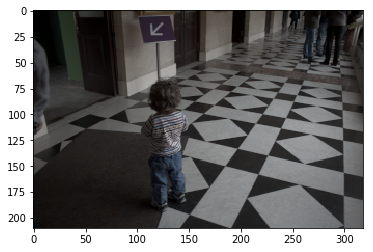

In [10]:
plt.imshow(srgb.astype(np.uint8))